# Scenario 1

| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation | Docs, Examples | Synthetic tests |
|---------------|-----------|------------|-----|-----------|------------|----------------|-----------------|
| Observational | Binary    | Continuous | No  | No        | No         | No             | No              |

## Generate data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

confounder_specs = [
    {"name": "tenure_months", "dist": "normal", "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal", "mu": 5, "sd": 2},
    {"name": "spend_last_month", "dist": "uniform", "a": 0, "b": 200},
    {"name": "premium_user", "dist": "bernoulli", "p": 0.25},
    {"name": "urban_resident", "dist": "bernoulli", "p": 0.60},
]

# Causal effect and noise
theta = 1.8  # ATE: +1.8 ARPU units if new_feature = 1
sigma_y = 3.5  # ARPU noise std
target_t_rate = 0.35  # ~35% treated

# Effects of confounders on ARPU (baseline, additive)
# Order: tenure_months, avg_sessions_week, spend_last_month, premium_user, urban_resident
beta_y = np.array([
    0.05,  # tenure_months: small positive effect
    0.40,  # avg_sessions_week: strong positive effect
    0.02,  # spend_last_month: recent spend correlates with ARPU
    2.00,  # premium_user: premium users have higher ARPU
    1.00,  # urban_resident: urban users slightly higher ARPU
], dtype=float)

# Effects of confounders on treatment assignment (log-odds scale)
beta_t = np.array([
    0.015,  # tenure_months
    0.10,  # avg_sessions_week
    0.002,  # spend_last_month
    0.75,  # premium_user
    0.30,  # urban_resident: more likely to get the feature
], dtype=float)

gen = CausalDatasetGenerator(
    theta=theta,
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    confounder_specs=confounder_specs,
    beta_y=beta_y,
    beta_t=beta_t,
)


# Create dataset
causal_data = gen.to_causal_data(
    n=5000,
    cofounders = [
    "tenure_months",
    "avg_sessions_week",
    "spend_last_month",
    "premium_user",
    "urban_resident",
]
)

print(f"Generated {len(causal_data.df)} observations")
print(f"True causal effect: {gen.theta}")
print(f"Treatment rate: {causal_data.df['t'].mean():.1%}")
print(f"Average outcome: {causal_data.df['y'].mean():.2f}")

# Show first few rows
causal_data.df.head()


Generated 5000 observations
True causal effect: 1.8
Treatment rate: 34.1%
Average outcome: 6.88


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,9.001966,0.0,27.656605,4.484096,156.289662,0.0,1.0
1,8.253476,0.0,11.520191,4.401028,49.867370,1.0,0.0
2,7.996043,1.0,33.005414,3.606680,164.168275,0.0,1.0
3,8.347067,0.0,35.286777,5.856966,35.426710,0.0,0.0
4,5.505211,1.0,0.587578,5.469292,71.894705,0.0,0.0


## EDA


In [10]:
from causalkit.eda import CausalEDA


In [11]:
eda = CausalEDA(causal_data)

In [12]:
# 1) Simple outcome/treatment summaries
summ = eda.summaries()
print("Share treated:", round(float(summ["treatment_rate"]), 4))
print("Naive diff (treated - control):",
      round(float(summ["naive_diff"]), 4) if pd.notna(summ["naive_diff"]) else summ["naive_diff"])

print("\nOutcome by treatment:")
display(summ["outcome_by_treatment"])

Share treated: 0.3412
Naive diff (treated - control): 2.4398

Outcome by treatment:


,count,mean,std
t,,,
0.0,3294,6.049281,3.961794
1.0,1706,8.489068,3.937085


In [13]:
summ

{'treatment_rate': np.float64(0.3412),
 'outcome_by_treatment':      count      mean       std
 t                             
 0.0   3294  6.049281  3.961794
 1.0   1706  8.489068  3.937085,
 'naive_diff': np.float64(2.4397874992846997)}

In [14]:
# Propensity, predictability (AUC), and positivity
ps = eda.fit_propensity()
auc = eda.treatment_predictability_auc(ps)
pos = eda.positivity_check(ps)

print("Treatment predictability AUC:", round(auc, 4))
print("Positivity check:", pos)

Treatment predictability AUC: 0.5964
Positivity check: {'bounds': (0.05, 0.95), 'share_below': 0.002, 'share_above': 0.0, 'flag': False}


In [15]:
# Treatment feature importance (which features drive treatment assignment)
features_df = eda.treatment_features()
print("Feature importance for treatment prediction:")
display(features_df)

Feature importance for treatment prediction:


,feature,shap_mean
0,tenure_months,0.000929
1,avg_sessions_week,-0.000339
2,spend_last_month,-0.000290
3,premium_user,-0.000271
4,urban_resident,-0.000030


In [16]:
# 3) Balance diagnostics (SMD) for covariate assessment
balance_df = eda.balance_table()
display(balance_df.head(20))

,covariate,SMD
3,premium_user,0.329364
1,avg_sessions_week,0.198836
0,tenure_months,0.172035
4,urban_resident,0.100418
2,spend_last_month,0.080595


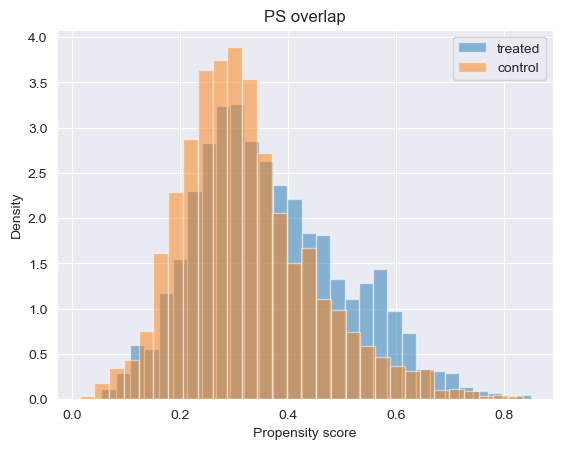

In [17]:
# 4) Propensity score overlap
# Overlap plot (treated vs control propensity distributions)
eda.plot_ps_overlap(ps)
plt.show()

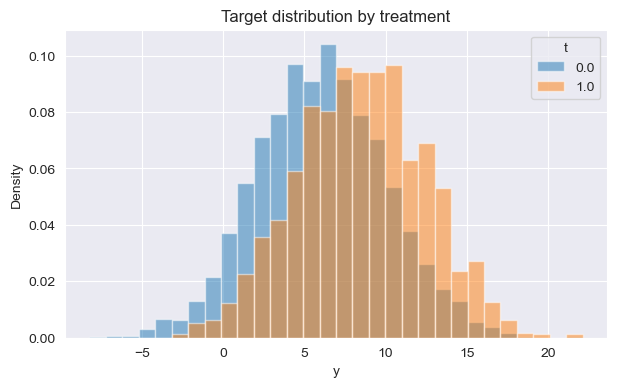

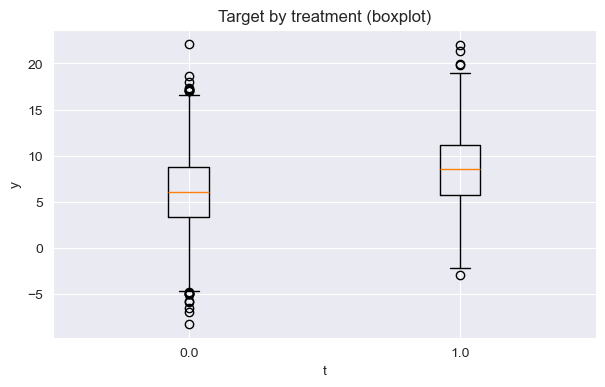

In [18]:
# 5) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.plot_target_by_treatment()
plt.show()

In [19]:
# 5) One-shot consolidated report (if you prefer a single call)
report = eda.design_report()
# Example: access parts
print("AUC:", report["treat_auc"])
print("Positivity:", report["positivity"])
print("Balance variables:", len(report["balance"]))

AUC: 0.5964160208870297
Positivity: {'bounds': (0.05, 0.95), 'share_below': 0.002, 'share_above': 0.0, 'flag': False}
Balance variables: 5


In [20]:
report

{'summaries': {'treatment_rate': np.float64(0.3412),
  'outcome_by_treatment':      count      mean       std
  t                             
  0.0   3294  6.049281  3.961794
  1.0   1706  8.489068  3.937085,
  'naive_diff': np.float64(2.4397874992846997)},
 'treat_auc': 0.5964160208870297,
 'positivity': {'bounds': (0.05, 0.95),
  'share_below': 0.002,
  'share_above': 0.0,
  'flag': False},
 'balance':            covariate       SMD
 3       premium_user  0.329364
 1  avg_sessions_week  0.198836
 0      tenure_months  0.172035
 4     urban_resident  0.100418
 2   spend_last_month  0.080595}

In [28]:
print("=== DIRECT CHAINING EXAMPLE ===")
print(eda.design_report().summary())

=== DIRECT CHAINING EXAMPLE ===
CAUSAL DESIGN REPORT SUMMARY

📊 TREATMENT & OUTCOME SUMMARY
------------------------------
Treatment Rate: 34.1%
Naive Difference (Treated - Control): 2.4398

Outcome by Treatment:
     count    mean     std
t                         
0.0   3294  6.0493  3.9618
1.0   1706  8.4891  3.9371

🎯 TREATMENT PREDICTABILITY
------------------------------
Treatment AUC: 0.5964
  ✅ Low predictability - minimal confounding risk

🔄 POSITIVITY/OVERLAP ASSESSMENT
------------------------------
Propensity Score Bounds: (0.05, 0.95)
Share Below Lower Bound: 0.2%
Share Above Upper Bound: 0.0%
Total in Extreme Regions: 0.2%
  ✅ Good overlap - positivity assumption satisfied

⚖️  COVARIATE BALANCE ASSESSMENT
------------------------------
Total Variables: 5
Imbalanced Variables: 4
  ⚠️  Poor balance - many imbalanced variables

Most Imbalanced Variables:
  premium_user: 0.329
  avg_sessions_week: 0.199
  tenure_months: 0.172

📋 OVERALL ASSESSMENT
---------------------------

## Inference

In [21]:
# Import inference methods
from causalkit.inference.ate import dml_ate
from causalkit.inference.att import dml_att

# Estimate Average Treatment Effect (ATE)
print("=== ORIGINAL CAUSAL ESTIMATES ===")
ate_result = dml_ate(causal_data, n_folds=3, confidence_level=0.95)
print(f"ATE Estimate: {ate_result['coefficient']:.3f}")
print(f"ATE 95% CI: [{ate_result['confidence_interval'][0]:.3f}, {ate_result['confidence_interval'][1]:.3f}]")
print(f"ATE p-value: {ate_result['p_value']:.6f}")
print(f"True effect: {gen.theta:.3f}")



=== ORIGINAL CAUSAL ESTIMATES ===
ATE Estimate: 1.849
ATE 95% CI: [1.615, 2.084]
ATE p-value: 0.000000
True effect: 1.800


## Refutation

In [22]:
# Import refutation utilities
from causalkit.refutation import (
    refute_placebo_outcome,
    refute_placebo_treatment,
    refute_subset,
)


In [23]:
print("--- Placebo Outcome Test ---")
print("Shuffling outcome variable (breaking outcome-treatment link)")
print("Expected: θ ≈ 0, large p-value\n")

# Test with ATE estimator
ate_placebo_outcome = refute_placebo_outcome(
    dml_ate,
    causal_data,
    random_state=42
)

print(f"ATE with shuffled outcome:")
print(f"  θ = {ate_placebo_outcome['theta']:.4f}")
print(f"  p-value = {ate_placebo_outcome['p_value']:.4f}")



--- Placebo Outcome Test ---
Shuffling outcome variable (breaking outcome-treatment link)
Expected: θ ≈ 0, large p-value

ATE with shuffled outcome:
  θ = -0.0046
  p-value = 0.4901


In [24]:
print("\n--- Placebo Treatment Test ---")
print("Shuffling treatment variable (breaking treatment-outcome link)")
print("Expected: θ ≈ 0, large p-value\n")

# Test with ATE estimator
ate_placebo_treatment = refute_placebo_treatment(
    dml_ate,
    causal_data,
    random_state=42
)

print(f"ATE with shuffled treatment:")
print(f"  θ = {ate_placebo_treatment['theta']:.4f}")
print(f"  p-value = {ate_placebo_treatment['p_value']:.4f}")


--- Placebo Treatment Test ---
Shuffling treatment variable (breaking treatment-outcome link)
Expected: θ ≈ 0, large p-value

ATE with shuffled treatment:
  θ = 0.1105
  p-value = 0.3445


In [25]:
print("\n--- Subset Robustness Test ---")
print("Testing stability on random subsets of data")
print("Expected: θ similar to original estimate\n")

# Test multiple subset sizes
subset_fractions = [0.6, 0.8, 0.9]

print("ATE Subset Tests:")
print(f"Original ATE: {ate_result['coefficient']:.4f}")

ate_subset_results = []
for fraction in subset_fractions:
    subset_result = refute_subset(
        dml_ate,
        causal_data,
        fraction=fraction,
        random_state=42
    )
    ate_subset_results.append(subset_result)

    print(f"  {fraction*100:.0f}% subset: θ = {subset_result['theta']:.4f}, p = {subset_result['p_value']:.4f}")



--- Subset Robustness Test ---
Testing stability on random subsets of data
Expected: θ similar to original estimate

ATE Subset Tests:
Original ATE: 1.8494
  60% subset: θ = 1.7803, p = 0.0000
  80% subset: θ = 1.8781, p = 0.0000
  90% subset: θ = 1.7714, p = 0.0000


In [26]:
# Import sensitivity analysis functions
from causalkit.refutation import sensitivity_analysis, get_sensitivity_summary

In [27]:
print("--- Basic Sensitivity Analysis ---")
print("Testing robustness to unobserved confounding\n")

# Perform sensitivity analysis with moderate confounding assumptions
print("Scenario 1: Moderate unobserved confounding")
print("cf_y=0.03 (outcome confounding), cf_d=0.03 (treatment confounding)")

try:
    # Run sensitivity analysis on our ATE result
    sensitivity_report_1 = sensitivity_analysis(
        ate_result,
        cf_y=0.03,  # Confounding strength affecting outcome
        cf_d=0.03,  # Confounding strength affecting treatment
        rho=1.0     # Perfect correlation between unobserved confounders
    )

    print(sensitivity_report_1)

except Exception as e:
    print(f"Note: Sensitivity analysis requires the model object to support it.")
    print(f"Error: {e}")
    print("\nThis feature works best with DoubleML models that have sensitivity analysis capabilities.")

--- Basic Sensitivity Analysis ---
Testing robustness to unobserved confounding

Scenario 1: Moderate unobserved confounding
cf_y=0.03 (outcome confounding), cf_d=0.03 (treatment confounding)
================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
   CI lower  theta lower    theta  theta upper  CI upper
t  1.410706     1.607674  1.84936     2.091046  2.287668

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
t  0.0  20.749473  18.725578
